# Leitura e Pré-processamento dos Registros da Base MIT-BIH

Este notebook realiza a leitura, pré-processamento e análise dos registros da base MIT-BIH Arrhythmia Database.

## Etapas do processo:
1. Carregar e verificar os registros disponíveis.
2. Processar os registros com o canal MLII (canal padrão de ECG).
3. Tratar os registros com morfologias atípicas e ritmos acelerados.
3. Extrair os batimentos cardíacos e suas classes.
4. Salvar os dados extraídos em um arquivo CSV.

## Importação das Bibliotecas

In [14]:
import wfdb
from wfdb import rdrecord
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from shutil import copyfile


## Definição dos registros, caminho dos Arquivos, iteração sobre os registros e exibição dos canais disponíveis

O código irá iterar sobre cada um desses registros e verificar os canais disponíveis.


In [4]:
registros = [
    '100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
    '111', '112', '113', '114', '115', '116', '117', '118', '119',
    '121', '122', '123', '124', '200', '201', '202', '203', '205', '207',
    '208', '209', '210', '212', '213', '214', '215', '217', '219', '220',
    '221', '222', '223', '228', '230', '231', '232', '233', '234'
]

local_path = '/home/joaovfg/PFC-WPW/mit-bih-arrhythmia-database-1.0.0/'

for reg in registros:
    try:
        record = rdrecord(os.path.join(local_path, reg))
        canais = record.sig_name
        print(f'Registro {reg}: Canais disponíveis -> {canais}')
    except Exception as e:
        print(f'Erro ao carregar registro {reg}: {e}')

Registro 100: Canais disponíveis -> ['MLII', 'V5']
Registro 101: Canais disponíveis -> ['MLII', 'V1']
Registro 102: Canais disponíveis -> ['V5', 'V2']
Registro 103: Canais disponíveis -> ['MLII', 'V2']
Registro 104: Canais disponíveis -> ['V5', 'V2']
Registro 105: Canais disponíveis -> ['MLII', 'V1']
Registro 106: Canais disponíveis -> ['MLII', 'V1']
Registro 107: Canais disponíveis -> ['MLII', 'V1']
Registro 108: Canais disponíveis -> ['MLII', 'V1']
Registro 109: Canais disponíveis -> ['MLII', 'V1']
Registro 111: Canais disponíveis -> ['MLII', 'V1']
Registro 112: Canais disponíveis -> ['MLII', 'V1']
Registro 113: Canais disponíveis -> ['MLII', 'V1']
Registro 114: Canais disponíveis -> ['V5', 'MLII']
Registro 115: Canais disponíveis -> ['MLII', 'V1']
Registro 116: Canais disponíveis -> ['MLII', 'V1']
Registro 117: Canais disponíveis -> ['MLII', 'V2']
Registro 118: Canais disponíveis -> ['MLII', 'V1']
Registro 119: Canais disponíveis -> ['MLII', 'V1']
Registro 121: Canais disponíveis ->

## Processamento de Registros com Canal MLII

Verifica-se se o canal MLII está presente em cada registro e carrega-se apenas esse canal, caso disponível.

In [5]:
# Dicionário para armazenar registros com canal MLII
registros_com_mlII = {}

# Primeiro, carregamos os registros com canal MLII
for reg in registros:
    try:
        record = rdrecord(os.path.join(local_path, reg), channels=None)
        canais = record.sig_name

        # Verifica se o canal MLII está presente
        if 'MLII' not in canais:
            print(f"Registro {reg} ignorado: canal MLII não encontrado.")
            continue

        idx_mlII = canais.index('MLII')
        record_mlII = rdrecord(os.path.join(local_path, reg), channels=[idx_mlII])

        registros_com_mlII[reg] = record_mlII
        print(f"Registro {reg} carregado com canal MLII (índice {idx_mlII}).")

    except Exception as e:
        print(f"Erro ao processar registro {reg}: {e}")

Registro 100 carregado com canal MLII (índice 0).
Registro 101 carregado com canal MLII (índice 0).
Registro 102 ignorado: canal MLII não encontrado.
Registro 103 carregado com canal MLII (índice 0).
Registro 104 ignorado: canal MLII não encontrado.
Registro 105 carregado com canal MLII (índice 0).
Registro 106 carregado com canal MLII (índice 0).
Registro 107 carregado com canal MLII (índice 0).
Registro 108 carregado com canal MLII (índice 0).
Registro 109 carregado com canal MLII (índice 0).
Registro 111 carregado com canal MLII (índice 0).
Registro 112 carregado com canal MLII (índice 0).
Registro 113 carregado com canal MLII (índice 0).
Registro 114 carregado com canal MLII (índice 1).
Registro 115 carregado com canal MLII (índice 0).
Registro 116 carregado com canal MLII (índice 0).
Registro 117 carregado com canal MLII (índice 0).
Registro 118 carregado com canal MLII (índice 0).
Registro 119 carregado com canal MLII (índice 0).
Registro 121 carregado com canal MLII (índice 0).


## Tratamento de registros com morfologias atípicas e ritmos acelerados

Os registros 108, 111 e 124 possuem morfologias atípicas, enquanto os registros 200, 203 e 207 possuem o mesmo com ritmos acelerados, o que atrapalha na segmentação dos sinais.

In [6]:
# Registros a serem excluídos devido a morfologias atípicas e ritmos acelerados
registros_excluir = ['108', '111', '124', '200', '203', '207']

# Lista para armazenar os registros filtrados
registros_filtrados_com_mlII = {}

# Agora, verificamos e removemos os registros a serem excluídos
for reg, record in registros_com_mlII.items():
    if reg in registros_excluir:
        print(f"Registro {reg} excluído devido a morfologias atípicas ou ritmos acelerados.")
        continue  # Exclui o registro

    # Se o registro não for excluído, é armazenado na lista de registros filtrados
    registros_filtrados_com_mlII[reg] = record
    print(f"Registro {reg} mantido após verificação.")


Registro 100 mantido após verificação.
Registro 101 mantido após verificação.
Registro 103 mantido após verificação.
Registro 105 mantido após verificação.
Registro 106 mantido após verificação.
Registro 107 mantido após verificação.
Registro 108 excluído devido a morfologias atípicas ou ritmos acelerados.
Registro 109 mantido após verificação.
Registro 111 excluído devido a morfologias atípicas ou ritmos acelerados.
Registro 112 mantido após verificação.
Registro 113 mantido após verificação.
Registro 114 mantido após verificação.
Registro 115 mantido após verificação.
Registro 116 mantido após verificação.
Registro 117 mantido após verificação.
Registro 118 mantido após verificação.
Registro 119 mantido após verificação.
Registro 121 mantido após verificação.
Registro 122 mantido após verificação.
Registro 123 mantido após verificação.
Registro 124 excluído devido a morfologias atípicas ou ritmos acelerados.
Registro 200 excluído devido a morfologias atípicas ou ritmos acelerados.
Re

## Extração de batimentos e classes

Extrai-se os batimentos cardíacos dos registros, classificando-os em duas categorias:
- **0**: Batimentos não relacionados ao WPW.
- **1**: Batimentos relacionados ao WPW.

Essa classificação é feita com base nas anotações dos registros.


In [7]:
nao_wpw_labels = ['N', 'R', 'L', 'f', 'F', '/', 'V', 'A', 'a', 'j']
wpw_label = '*'

batimentos = []

# Inicializa os contadores
contagem_nao_wpw = 0
contagem_wpw = 0

for reg, record in registros_filtrados_com_mlII.items():
    try:
        atr_path = os.path.join(local_path, f"{reg}_modified")
        if not os.path.exists(f"{atr_path}.atr"):
            atr_path = os.path.join(local_path, reg)

        annotation = wfdb.rdann(atr_path, 'atr')

        for idx, symbol in enumerate(annotation.symbol):
            if symbol in nao_wpw_labels:
                batimentos.append({
                    'record': reg,
                    'sample': annotation.sample[idx],
                    'symbol': symbol,
                    'class': 0  # Não WPW
                })
                contagem_nao_wpw += 1  # Incrementa a contagem de batimentos não WPW
            elif symbol == wpw_label:
                batimentos.append({
                    'record': reg,
                    'sample': annotation.sample[idx],
                    'symbol': symbol,
                    'class': 1  # WPW
                })
                contagem_wpw += 1  # Incrementa a contagem de batimentos WPW

        print(f"Registro {reg}: {len(annotation.sample)} anotações lidas, {len([b for b in batimentos if b['record'] == reg])} relevantes.")

    except Exception as e:
        print(f"Erro ao ler anotações do registro {reg}: {e}")

# Exibe o total de amostras relevantes por classe
print(f"\nTotal de amostras relevantes:")
print(f"Classe 0 (Não WPW): {contagem_nao_wpw} batimentos")
print(f"Classe 1 (WPW): {contagem_wpw} batimentos")

# Exibe o total geral
total_batimentos = contagem_nao_wpw + contagem_wpw
print(f"Total de batimentos: {total_batimentos}")


Registro 100: 2274 anotações lidas, 2273 relevantes.
Registro 101: 1874 anotações lidas, 1863 relevantes.
Registro 103: 2091 anotações lidas, 2084 relevantes.
Registro 105: 2691 anotações lidas, 2567 relevantes.
Registro 106: 2098 anotações lidas, 2027 relevantes.
Registro 107: 2140 anotações lidas, 2137 relevantes.
Registro 109: 2535 anotações lidas, 2532 relevantes.
Registro 112: 2550 anotações lidas, 2539 relevantes.
Registro 113: 1796 anotações lidas, 1795 relevantes.
Registro 114: 1890 anotações lidas, 1877 relevantes.
Registro 115: 1962 anotações lidas, 1953 relevantes.
Registro 116: 2421 anotações lidas, 2412 relevantes.
Registro 117: 1539 anotações lidas, 1535 relevantes.
Registro 118: 2301 anotações lidas, 2278 relevantes.
Registro 119: 2094 anotações lidas, 1987 relevantes.
Registro 121: 1876 anotações lidas, 1863 relevantes.
Registro 122: 2479 anotações lidas, 2476 relevantes.
Registro 123: 1519 anotações lidas, 1518 relevantes.
Registro 201: 2039 anotações lidas, 1962 relev

## Criação do DataFrame e Salvamento em CSV

Após extrair os batimentos e suas classes, adiciona-se a coluna "channel" para indicar o canal de ECG utilizado (MLII). Em seguida, cria-se um DataFrame e salva-se os dados em um arquivo CSV.


In [8]:
# Adiciona a coluna 'channel'
for b in batimentos:
    b['channel'] = 'MLII'

# Cria o DataFrame
df_batimentos = pd.DataFrame(batimentos, columns=['record', 'sample', 'symbol', 'channel', 'class'])

# Exibe o DataFrame no console
print(df_batimentos)

      record  sample symbol channel  class
0        100      77      N    MLII      0
1        100     370      N    MLII      0
2        100     662      N    MLII      0
3        100     946      N    MLII      0
4        100    1231      N    MLII      0
...      ...     ...    ...     ...    ...
92042    234  648797      N    MLII      0
92043    234  649040      N    MLII      0
92044    234  649292      N    MLII      0
92045    234  649536      N    MLII      0
92046    234  649772      N    MLII      0

[92047 rows x 5 columns]


In [9]:
# Salva o DataFrame em um arquivo CSV
df_batimentos.to_csv('/home/joaovfg/PFC-WPW/csv/batimentos_filtrados.csv', index=False)
print("Arquivo 'batimentos_filtrados.csv' salvo com sucesso.")

Arquivo 'batimentos_filtrados.csv' salvo com sucesso.


# Segmentação e normalização dos registros 

In [10]:
# Configurações da janela de segmentação
window_left = 76
window_right = 140
segment_length = window_left + window_right

# Caminhos principais
local_path = '/home/joaovfg/PFC-WPW/mit-bih-arrhythmia-database-1.0.0/'
output_base_path = '/home/joaovfg/PFC-WPW/mit-bih-segmented-signals/'

In [11]:
# Agrupa o carregamento de sinais para não recarregar o mesmo registro várias vezes
sinais_cache = {}

segmentos_por_classe = {0: 0, 1: 0}
total_segmentos = 0

# Itera sobre cada batimento do DataFrame
for i, row in tqdm(df_batimentos.iterrows(), total=len(df_batimentos), desc="Segmentando batimentos"):

    reg = str(row['record'])
    sample = int(row['sample'])
    classe = int(row['class'])

    if reg in registros_excluir:
        print(f"Registro {reg} excluído (morfologia ou ritmo inadequado).")
        continue

    if reg not in sinais_cache:
        try:
            record_path = os.path.join(local_path, reg)
            record = wfdb.rdrecord(record_path)

            if 'MLII' not in record.sig_name:
                print(f"Registro {reg} não contém canal MLII. Ignorado.")
                continue

            idx_mlII = record.sig_name.index('MLII')
            record = wfdb.rdrecord(record_path, channels=[idx_mlII])
            sinal = record.p_signal[:, 0]

            sinais_cache[reg] = sinal
            print(f"\nSegmentando registro {reg}...")
        except Exception as e:
            print(f"Erro ao carregar o registro {reg}: {e}")
            continue
    else:
        sinal = sinais_cache[reg]

    inicio = sample - window_left
    fim = sample + window_right

    if inicio < 0 or fim > len(sinal):
        print(f"Amostra fora dos limites em {reg}, sample {sample}")
        continue

    segmento = sinal[inicio:fim]

    min_val, max_val = np.min(segmento), np.max(segmento)
    if max_val - min_val == 0:
        print(f"Amostra com sinal constante em {reg}, sample {sample}")
        continue

    segmento_normalizado = (segmento - min_val) / (max_val - min_val)

    # Diretórios organizados por classe (0 ou 1)
    class_dir = os.path.join(output_base_path, str(classe))
    segments_dir = os.path.join(class_dir)
    #labels_dir = os.path.join(class_dir, 'labels')

    os.makedirs(segments_dir, exist_ok=True)
    #os.makedirs(labels_dir, exist_ok=True)

    idx_classe = segmentos_por_classe[classe]
    seg_filename = f'segment_{reg}_{sample}_{classe}_{idx_classe:05d}.dat'
    #label_filename = f'label_{reg}_{sample}_{classe}_{idx_classe:05d}.npy'

    segmento_path = os.path.join(segments_dir, seg_filename)
    #label_path = os.path.join(labels_dir, label_filename)

    segmento_normalizado.astype('float32').tofile(segmento_path)
    #np.save(label_path, np.array(classe, dtype='int32'))

    segmentos_por_classe[classe] += 1
    total_segmentos += 1

print("\nResumo de segmentos por classe:")
for classe, count in segmentos_por_classe.items():
    print(f"  Classe {classe}: {count} segmentos")

print(f"\nSegmentação finalizada. Total de segmentos salvos: {total_segmentos}")

Segmentando batimentos:   1%|          | 1035/92047 [00:00<00:16, 5536.72it/s]


Segmentando registro 100...


Segmentando batimentos:   3%|▎         | 2995/92047 [00:00<00:15, 5891.29it/s]

Amostra fora dos limites em 100, sample 649991

Segmentando registro 101...


Segmentando batimentos:   5%|▌         | 4861/92047 [00:00<00:15, 5465.39it/s]


Segmentando registro 103...


Segmentando batimentos:   8%|▊         | 7150/92047 [00:01<00:15, 5438.27it/s]

Amostra fora dos limites em 103, sample 649875

Segmentando registro 105...


Segmentando batimentos:  10%|█         | 9478/92047 [00:01<00:15, 5321.20it/s]


Segmentando registro 106...


Segmentando batimentos:  13%|█▎        | 11797/92047 [00:02<00:15, 5308.39it/s]


Segmentando registro 107...


Segmentando batimentos:  15%|█▍        | 13709/92047 [00:02<00:13, 5683.35it/s]


Segmentando registro 109...


Segmentando batimentos:  17%|█▋        | 16081/92047 [00:03<00:15, 4781.10it/s]

Amostra fora dos limites em 109, sample 649931

Segmentando registro 112...


Segmentando batimentos:  21%|██        | 19192/92047 [00:03<00:12, 5905.40it/s]

Amostra fora dos limites em 112, sample 649883

Segmentando registro 113...


Segmentando batimentos:  22%|██▏       | 20513/92047 [00:03<00:11, 5994.08it/s]

Amostra fora dos limites em 113, sample 649994

Segmentando registro 114...


Segmentando batimentos:  25%|██▍       | 22571/92047 [00:04<00:11, 6217.42it/s]


Segmentando registro 115...


Segmentando batimentos:  27%|██▋       | 24654/92047 [00:04<00:10, 6328.09it/s]

Amostra fora dos limites em 115, sample 649955

Segmentando registro 116...


Segmentando batimentos:  29%|██▉       | 26723/92047 [00:04<00:10, 6212.85it/s]

Amostra fora dos limites em 116, sample 649957

Segmentando registro 117...


Segmentando batimentos:  31%|███       | 28088/92047 [00:05<00:10, 5958.50it/s]

Amostra fora dos limites em 117, sample 649926

Segmentando registro 118...
Amostra fora dos limites em 118, sample 68


Segmentando batimentos:  33%|███▎      | 30622/92047 [00:05<00:11, 5172.88it/s]


Segmentando registro 119...


Segmentando batimentos:  36%|███▌      | 33025/92047 [00:05<00:10, 5453.76it/s]


Segmentando registro 121...


Segmentando batimentos:  37%|███▋      | 34114/92047 [00:06<00:13, 4179.45it/s]

Amostra fora dos limites em 121, sample 649878

Segmentando registro 122...


Segmentando batimentos:  40%|████      | 36893/92047 [00:06<00:12, 4354.56it/s]

Amostra fora dos limites em 122, sample 649905

Segmentando registro 123...
Amostra fora dos limites em 123, sample 70


Segmentando batimentos:  42%|████▏     | 38362/92047 [00:07<00:12, 4199.63it/s]


Segmentando registro 201...


Segmentando batimentos:  44%|████▍     | 40688/92047 [00:07<00:10, 4751.54it/s]


Segmentando registro 202...


Segmentando batimentos:  46%|████▋     | 42722/92047 [00:08<00:10, 4692.44it/s]

Amostra fora dos limites em 202, sample 649877

Segmentando registro 205...


Segmentando batimentos:  50%|████▉     | 45806/92047 [00:08<00:07, 5861.48it/s]


Segmentando registro 208...
Amostra fora dos limites em 208, sample 46


Segmentando batimentos:  53%|█████▎    | 48371/92047 [00:09<00:07, 6038.57it/s]

Amostra fora dos limites em 208, sample 649935

Segmentando registro 209...


Segmentando batimentos:  56%|█████▋    | 51796/92047 [00:09<00:06, 6460.33it/s]


Segmentando registro 210...
Amostra fora dos limites em 210, sample 57


Segmentando batimentos:  59%|█████▊    | 53878/92047 [00:10<00:05, 6438.91it/s]

Amostra fora dos limites em 210, sample 649962

Segmentando registro 212...


Segmentando batimentos:  62%|██████▏   | 56660/92047 [00:10<00:05, 6162.57it/s]

Amostra fora dos limites em 212, sample 649945

Segmentando registro 213...


Segmentando batimentos:  65%|██████▍   | 59811/92047 [00:11<00:05, 5597.96it/s]

Amostra fora dos limites em 213, sample 649992

Segmentando registro 214...
Amostra fora dos limites em 214, sample 58


Segmentando batimentos:  68%|██████▊   | 62193/92047 [00:11<00:05, 5272.78it/s]

Amostra fora dos limites em 214, sample 649891

Segmentando registro 215...


Segmentando batimentos:  71%|███████▏  | 65612/92047 [00:12<00:04, 6309.89it/s]

Amostra fora dos limites em 215, sample 649875

Segmentando registro 217...


Segmentando batimentos:  74%|███████▎  | 67724/92047 [00:12<00:03, 6474.10it/s]


Segmentando registro 219...


Segmentando batimentos:  76%|███████▌  | 69845/92047 [00:12<00:03, 6498.47it/s]


Segmentando registro 220...
Amostra fora dos limites em 220, sample 28


Segmentando batimentos:  78%|███████▊  | 71828/92047 [00:13<00:03, 5141.39it/s]

Amostra fora dos limites em 220, sample 649904

Segmentando registro 221...


Segmentando batimentos:  81%|████████  | 74495/92047 [00:13<00:02, 5948.52it/s]


Segmentando registro 222...


Segmentando batimentos:  84%|████████▎ | 76955/92047 [00:14<00:02, 5471.74it/s]


Segmentando registro 223...


Segmentando batimentos:  86%|████████▋ | 79406/92047 [00:14<00:02, 5314.24it/s]


Segmentando registro 228...


Segmentando batimentos:  89%|████████▊ | 81563/92047 [00:14<00:02, 4514.95it/s]


Segmentando registro 230...
Amostra fora dos limites em 230, sample 75


Segmentando batimentos:  91%|█████████ | 83929/92047 [00:15<00:01, 5153.24it/s]


Segmentando registro 231...


Segmentando batimentos:  93%|█████████▎| 85148/92047 [00:15<00:01, 5344.86it/s]

Amostra fora dos limites em 231, sample 649862

Segmentando registro 232...


Segmentando batimentos:  95%|█████████▍| 87427/92047 [00:16<00:00, 5274.18it/s]


Segmentando registro 233...
Amostra fora dos limites em 233, sample 42


Segmentando batimentos:  98%|█████████▊| 89848/92047 [00:16<00:00, 4909.13it/s]

Amostra fora dos limites em 233, sample 649946

Segmentando registro 234...


Segmentando batimentos: 100%|██████████| 92047/92047 [00:16<00:00, 5445.48it/s]


Resumo de segmentos por classe:
  Classe 0: 91104 segmentos
  Classe 1: 915 segmentos

Segmentação finalizada. Total de segmentos salvos: 92019


In [12]:
def carregar_segmentos(classe_dir):
    arquivos = sorted([f for f in os.listdir(classe_dir) if f.endswith('.dat')])
    segmentos = []
    for f in arquivos:
        path = os.path.join(classe_dir, f)
        # Carrega vetor float32 do arquivo binário
        segmento = np.fromfile(path, dtype='float32')
        segmentos.append(segmento)
    return segmentos

# Diretórios das classes
dir_classe_0 = os.path.join(output_base_path, '0')
dir_classe_1 = os.path.join(output_base_path, '1')

# Carrega os dados
segmentos_0 = carregar_segmentos(dir_classe_0)
segmentos_1 = carregar_segmentos(dir_classe_1)

print(f"Carregados {len(segmentos_0)} segmentos da classe 0")
print(f"Carregados {len(segmentos_1)} segmentos da classe 1")

Carregados 91104 segmentos da classe 0
Carregados 915 segmentos da classe 1


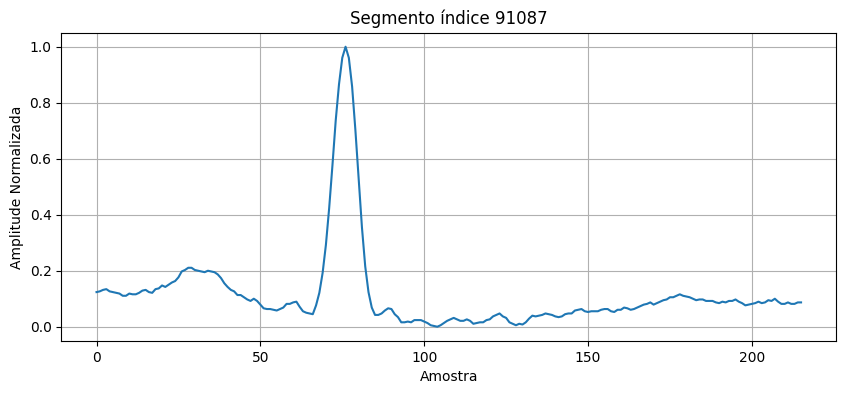

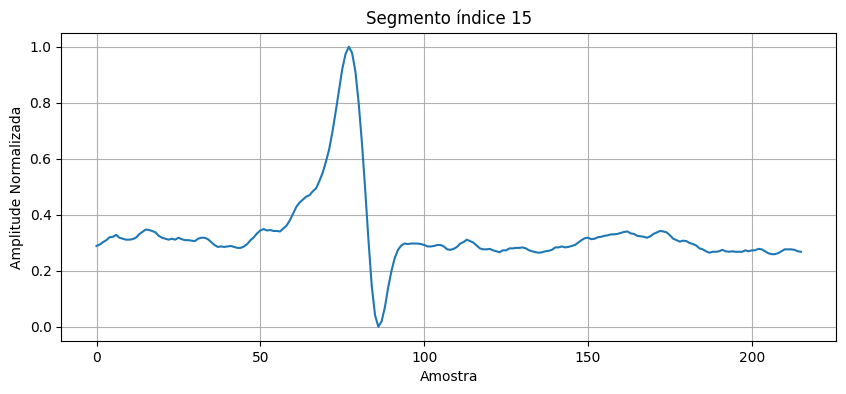

In [18]:
def plotar_segmento(segmentos, idx):
    if idx < 0 or idx >= len(segmentos):
        print("Índice fora do intervalo.")
        return
    plt.figure(figsize=(10,4))
    plt.plot(segmentos[idx])
    plt.title(f"Segmento índice {idx}")
    plt.xlabel("Amostra")
    plt.ylabel("Amplitude Normalizada")
    plt.grid(True)
    plt.show()

# Exemplo: plotar o segmento 0 da classe 0
plotar_segmento(segmentos_0, 91087)

# Exemplo: plotar o segmento 10 da classe 1
plotar_segmento(segmentos_1, 15)


# Organização e separação dos dados em treinamento, validação e teste